In [14]:
import numpy as np
import pandas as pd
import glob
import os
from astropy.io import fits
import matplotlib.pyplot as plt
from astropy.io import ascii
from astropy.table import Table
import itertools
from astroquery.simbad import Simbad
from utils import PLOT_PARAMS
from astropy import constants as const
from matplotlib import colors
PLOT_PARAMS()
import thejoker as tj

from datetime import date
today=date.today()
DATE =today.strftime("%m_%d_%y")
print(DATE)
import pickle
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib.colors as mcolors

plt.rcParams['figure.facecolor'] = 'white'
import warnings
warnings.filterwarnings("ignore")
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation
import astropy.units as u

vlt = EarthLocation.of_site('paranal')  # the easiest way... but requires internet

07_09_25


In [15]:
rv_df  = pd.read_csv('comb_rvs.csv')
table4 = pd.read_csv('table4.csv')

In [16]:
binary_list_113 = 1, 4, 5, 7, 9, 11, 16, 18, 19, 21, 23  
binary_list_112 = 5, 6, 7, 23 #13 removed because of dipper star

In [17]:
galah = Table.read('../../lithium/data/GALAH_DR3_main_allstar_v2.fits').to_pandas()

In [18]:
rv_df.keys()

Index(['sobject_id', 'logg', 'teff', 'RG_id', 'galah_id', 'obj_name',
       'esp_time', 'esp_rv', 'esp_rv_err', 'Li_val', 'e_Li_val', 'vbroad',
       'e_vbroad', 'fe_h', 'ruwe_dr2', 'Ba_fe', 'e_Ba_fe', 'La_fe', 'e_La_fe',
       'Zr_fe', 'e_Zr_fe', 'Y_fe', 'e_Y_fe', 'program', 'ra_dr2', 'dec_dr2',
       'dr3_source_id', 'MJD_local', 'rv_nogr_obst', 'e_rv_nogr_obst',
       'rv_galah', 'e_rv_galah', 'comb_time', 'comb_rv', 'comb_rv_err'],
      dtype='object')

In [19]:
abundances = []
abundance_err = []
for c in galah.keys():
    if '_fe' in c and 'flag_' not in c and 'nr' not in c and 'e_' not in c: 
        abundances.append(c)
        abundance_err.append('e_'+c)

16 18
K_fe
Zr_fe


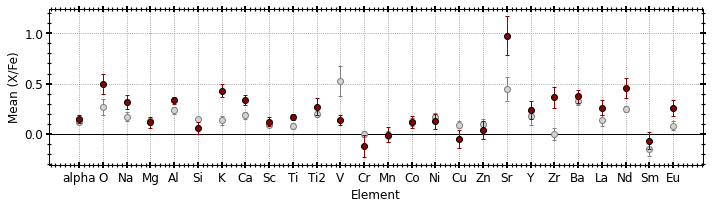

In [110]:
def get_abs(abundances, abundance_err,ax):
    PLOT_PARAMS(LS=12, SIZE=12)
    binary = rv_df[rv_df.sobject_id.isin(table4.sobject_id)]
    notbin = rv_df[~rv_df.sobject_id.isin(table4.sobject_id)]
    print(len(binary),len(notbin))

    # C, Cr2, Sc2 were removed b/c of NaN values
    # Li was removed b/c it was too large and I wanted to perserve the scale
    # Ru, Rb and Mo were removed b/c of insufficient data points
    abundances = [a for a in abundances if a not in ['Li_fe','C_fe','Cr2_fe','Sc2_fe', 'Ru_fe', 'Rb_fe', 'Mo_fe']]
    abundance_err = [a for a in abundance_err if a not in ['e_Li_fe','e_C_fe','e_Cr2_fe','e_Sc2_fe', 'e_Ru_fe', 'e_Rb_fe', 'e_Mo_fe']]
    # binary first
    d   = []
    d_e = []
    for i, row in binary.iterrows():
        sobject_id   = row.sobject_id
        ab_per_star  = galah[galah.sobject_id==sobject_id][abundances].values[0]
        err_per_star = galah[galah.sobject_id==sobject_id][abundance_err].values[0]
        ab_names     = [a[:-3] for a in abundances if '_fe' in a]
        d.append(ab_per_star)
        d_e.append(err_per_star)
        
    binary_d   = pd.DataFrame(d, columns=abundances)
    binary_err = pd.DataFrame(d_e, columns=abundances)
    
    # not binary next
    d   = []
    d_e = []
    for i, row in notbin.iterrows():
        sobject_id   = row.sobject_id
        ab_per_star  = galah[galah.sobject_id==sobject_id][abundances].values[0]
        err_per_star = galah[galah.sobject_id==sobject_id][abundance_err].values[0]
        ab_names     = [a[:-3] for a in abundances if '_fe' in a]
        d.append(ab_per_star)
        d_e.append(err_per_star)
        
    notbin_d   = pd.DataFrame(d, columns=abundances)
    notbin_err = pd.DataFrame(d_e, columns=abundances)
    
    # plotting
    for i,a in enumerate(abundances):
        N1         = notbin_d[a].count()
        err_notbin = np.std(notbin_d[a])/np.sqrt(N1)
        
        N2         = binary_d[a].count()
        err_binary = np.std(binary_d[a])/np.sqrt(N2)
        
        plt.errorbar(i, np.mean(notbin_d[a]), yerr=err_notbin, fmt='o', label='not binary', capsize=2,lw=1, color='lightgrey',mec='grey',ecolor='grey')
        plt.errorbar(i, np.mean(binary_d[a]), yerr=err_binary, fmt='o', label='binary',capsize=2,lw=1, color='darkred',mec='k',zorder=100)
        #if i==0: plt.legend(loc='upper center')
            
        # calculate 3-sigma difference:
        D       = abs(np.mean(notbin_d[a]) - np.mean(binary_d[a]))
        sigma_D = np.sqrt(err_notbin**2 + err_binary**2)
        if (D/sigma_D) >= 3: print(a)
        '''if i ==0: 
            print('A:\t N1 \t N2',)
            print(a,N1,'\t', N2)
        else:
            print(a, '\t',N1,'\t', N2)
            '''
    xlabels = [x[0:-3] for x in abundances]
    ax.set_xticks(np.arange(len(xlabels)))
    ax.set_xticklabels(xlabels)
    
    plt.grid(ls='dotted',c='grey')
    plt.ylabel('Mean (X/Fe)')
    plt.xlabel('Element')
    plt.axhline(0, c='k', lw=1)
    plt.tight_layout()
    #plt.savefig('../plots/abundance_%s.png'%DATE,bbox_inches='tight',dpi=150)

plt.figure(figsize=(10,3))
ax = plt.subplot(111)
get_abs(abundances,abundance_err,ax=ax)
plt.show()

In [21]:
(400*u.Mjup).to(u.Msun).value
(0.4*u.Msun).to(u.Mjup).value
(0.55*u.Msun).to(u.Mjup).value
abundances

['alpha_fe',
 'Li_fe',
 'C_fe',
 'O_fe',
 'Na_fe',
 'Mg_fe',
 'Al_fe',
 'Si_fe',
 'K_fe',
 'Ca_fe',
 'Sc_fe',
 'Sc2_fe',
 'Ti_fe',
 'Ti2_fe',
 'V_fe',
 'Cr_fe',
 'Cr2_fe',
 'Mn_fe',
 'Co_fe',
 'Ni_fe',
 'Cu_fe',
 'Zn_fe',
 'Rb_fe',
 'Sr_fe',
 'Y_fe',
 'Zr_fe',
 'Mo_fe',
 'Ru_fe',
 'Ba_fe',
 'La_fe',
 'Nd_fe',
 'Sm_fe',
 'Eu_fe']

16 18
6 3 5 2
16 18
K_fe
Zr_fe


V_fe 4.09 bd
Y_fe 5 0.16 bd
Zr_fe 3 2.24 bd
Ba_fe 6 2.34 bd
La_fe 4 1.09 bd


O_fe 3 2.14 wd
Na_fe 3 2.82 wd
K_fe 3.05 wd
K_fe 3 3.05 wd
Ca_fe 3 2.17 wd
Y_fe 2 0.25 wd
Zr_fe 1 1.33 wd
Ba_fe 3 1.38 wd
La_fe 1 2.15 wd


Sr_fe 3.14 md
Y_fe 5 0.2 md
Zr_fe 3 2.08 md
Ba_fe 5 0.43 md
La_fe 4 0.88 md




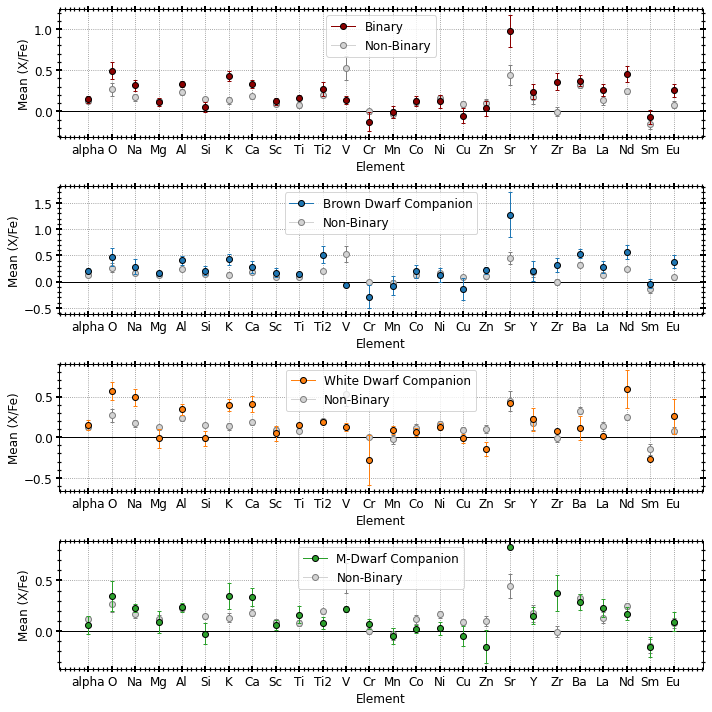

In [112]:
def abs_per_mass(abundances,abundance_err):
    PLOT_PARAMS(LS=12, SIZE=12)
    binary = rv_df[rv_df.sobject_id.isin(table4.sobject_id)]
    notbin = rv_df[~rv_df.sobject_id.isin(table4.sobject_id)]
    print(len(binary),len(notbin))
    
    wd_limit    = (0.4*u.Msun).to(u.Mjup).value
    md_limit1   = (0.08*u.Msun).to(u.Mjup).value
    md_limit2   = (0.55*u.Msun).to(u.Mjup).value
    brown_dwarf = table4[(table4.Mj50<=80) & (table4.Mj50>=13)]
    white_dwarf = table4[(table4.Mj50>=wd_limit)]
    other       = table4[(table4.Mj50<=13)]
    m_dwarf     = table4[(table4.Mj50<=md_limit2) & (table4.Mj50>=md_limit1)]

    print(len(brown_dwarf),len(white_dwarf),len(m_dwarf) ,len(other))
    brown_dwarf = binary[binary.sobject_id.isin(brown_dwarf.sobject_id)]
    white_dwarf = binary[binary.sobject_id.isin(white_dwarf.sobject_id)]
    
    # C, Cr2, Sc2 were removed b/c of NaN values
    # Li was removed b/c it was too large and I wanted to perserve the scale
    # Ru, Rb and Mo were removed b/c of insufficient data points
    abundances = [a for a in abundances if a not in ['Li_fe','C_fe','Cr2_fe','Sc2_fe', 'Ru_fe', 'Rb_fe', 'Mo_fe']]
    abundance_err = [a for a in abundance_err if a not in ['e_Li_fe','e_C_fe','e_Cr2_fe','e_Sc2_fe', 'e_Ru_fe', 'e_Rb_fe', 'e_Mo_fe']]
    
    def run_on_mass_group(binary,color,ax,label):
        # binary first
        d   = []
        d_e = []
        for i, row in binary.iterrows():
            sobject_id   = row.sobject_id
            ab_per_star  = galah[galah.sobject_id==sobject_id][abundances].values[0]
            err_per_star = galah[galah.sobject_id==sobject_id][abundance_err].values[0]
            ab_names     = [a[:-3] for a in abundances if '_fe' in a]
            d.append(ab_per_star)
            d_e.append(err_per_star)

        binary_d   = pd.DataFrame(d, columns=abundances)
        binary_err = pd.DataFrame(d_e, columns=abundances)

        # not binary next
        d   = []
        d_e = []
        for i, row in notbin.iterrows():
            sobject_id   = row.sobject_id
            ab_per_star  = galah[galah.sobject_id==sobject_id][abundances].values[0]
            err_per_star = galah[galah.sobject_id==sobject_id][abundance_err].values[0]
            ab_names     = [a[:-3] for a in abundances if '_fe' in a]
            d.append(ab_per_star)
            d_e.append(err_per_star)

        notbin_d   = pd.DataFrame(d, columns=abundances)
        notbin_err = pd.DataFrame(d_e, columns=abundances)

        # plotting
        
        for i,a in enumerate(abundances):
            N1         = notbin_d[a].count()
            err_notbin = np.std(notbin_d[a])/np.sqrt(N1)

            N2         = binary_d[a].count()
            err_binary = np.std(binary_d[a])/np.sqrt(N2)

            plt.errorbar(i, np.mean(notbin_d[a]), yerr=err_notbin, fmt='o', label='not binary', capsize=2,lw=1, color='lightgrey',mec='grey',ecolor='grey')
            plt.errorbar(i, np.mean(binary_d[a]), yerr=err_binary, fmt='o', label='binary',capsize=2,lw=1, color=color,mec='k',zorder=100)
            
            # calculate 3-sigma difference:
            D       = abs(np.mean(notbin_d[a]) - np.mean(binary_d[a]))
            sigma_D = np.sqrt(err_notbin**2 + err_binary**2)
            if (D/sigma_D) >= 3: print(a,round(D/sigma_D,2),label)
            if a in ['Zr_fe','Y_fe','La_fe','Ba_fe']: 
                print(a, N2, round((D/sigma_D), 2), label)
            if a in ['K_fe','Na_fe','O_fe','Ca_fe'] and label=='wd':
                print(a, N2, round((D/sigma_D), 2), label)
            '''if i ==0: 
                print('A:\t N1 \t N2',)
                print(a,N1,'\t', N2)
            else:
                print(a, '\t',N1,'\t', N2)'''
        xlabels = [x[0:-3] for x in abundances]
        ax.set_xticks(np.arange(len(xlabels)))
        ax.set_xticklabels(xlabels)

        plt.grid(ls='dotted',c='grey')
        plt.ylabel('Mean (X/Fe)')
        plt.xlabel('Element')
        plt.axhline(0, c='k', lw=1)
        plt.tight_layout()
        #plt.savefig('../plots/abundance_%s.png'%DATE,bbox_inches='tight',dpi=150)
        
    plt.figure(figsize=(10,10))
    ax0 = plt.subplot(411)
    get_abs(abundances,abundance_err,ax=ax0)
    print('\n')
    
    ax1 = plt.subplot(412)
    run_on_mass_group(brown_dwarf,color='C0',ax=ax1,label='bd')
    print('\n')

    ax2 = plt.subplot(413)
    run_on_mass_group(white_dwarf,color='C1',ax=ax2,label='wd')
    print('\n')
    
    ax3 = plt.subplot(414)
    run_on_mass_group(m_dwarf,color='C2',ax=ax3,label='md')
    print('\n')
    
    lgnd0 = [Line2D([0], [0], marker='o', label='Binary', mfc='darkred', color='darkred', mec='k', lw=1), 
             Line2D([0], [0], marker='o', label='Non-Binary', mfc='lightgrey', color='lightgrey', mec='grey',lw=1)]
    lgnd1 = [Line2D([0], [0], marker='o', label='Brown Dwarf Companion', mfc='C0', color='C0', mec='k', lw=1), 
             Line2D([0], [0], marker='o', label='Non-Binary', mfc='lightgrey', color='lightgrey', mec='grey',lw=1)]
    lgnd2 = [Line2D([0], [0], marker='o', label='White Dwarf Companion', mfc='C1', color='C1', mec='k', lw=1), 
             Line2D([0], [0], marker='o', label='Non-Binary', mfc='lightgrey', color='lightgrey', mec='grey',lw=1)]
    lgnd3 = [Line2D([0], [0], marker='o', label='M-Dwarf Companion', mfc='C2', color='C2', mec='k', lw=1), 
             Line2D([0], [0], marker='o', label='Non-Binary', mfc='lightgrey', color='lightgrey', mec='grey',lw=1)]


    
    ax0.legend(handles=lgnd0,loc='upper center')
    ax1.legend(handles=lgnd1,loc='upper center')
    ax2.legend(handles=lgnd2,loc='upper center')
    ax3.legend(handles=lgnd3,loc='upper center')
    plt.tight_layout()
    #plt.savefig('../plots/abundance_%s.png'%DATE,bbox_inches='tight',dpi=150)
    
    plt.show()
abs_per_mass(abundances,abundance_err)


6 3 5 2
26
bd 0.04713771820068402 0.8948712158203129 0.46586571216583295 0.17879472956304326 4
wd 0.2925557899475102 0.7498826789855961 0.5644963391621912 0.1134369078012826 3
md -0.02020074844360309 0.7758459854125981 0.34507244110107466 0.15088789887611 5


<Figure size 720x1440 with 0 Axes>

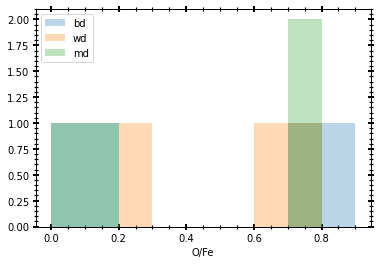

<Figure size 432x288 with 0 Axes>

In [179]:
def diagnostic_plot(abundances,abundance_err):
    PLOT_PARAMS(LS=12, SIZE=12)
    binary = rv_df[rv_df.sobject_id.isin(table4.sobject_id)]
    
    dg_table = pd.read_csv('../../lithium/final_paper_sample_09_18.csv')
    
    wd_limit    = (0.4*u.Msun).to(u.Mjup).value
    md_limit1   = (0.08*u.Msun).to(u.Mjup).value
    md_limit2   = (0.55*u.Msun).to(u.Mjup).value
    brown_dwarf = table4[(table4.Mj50<=80) & (table4.Mj50>=13)]
    white_dwarf = table4[(table4.Mj50>=wd_limit)]
    other       = table4[(table4.Mj50<=13)]
    m_dwarf     = table4[(table4.Mj50<=md_limit2) & (table4.Mj50>=md_limit1)]

    print(len(brown_dwarf),len(white_dwarf),len(m_dwarf) ,len(other))
    
    brown_dwarf = binary[binary.sobject_id.isin(brown_dwarf.sobject_id)]
    white_dwarf = binary[binary.sobject_id.isin(white_dwarf.sobject_id)]
    m_dwarf     = binary[binary.sobject_id.isin(m_dwarf.sobject_id)]
    
    REFRACTORY  = ['Zr_fe','Ni_fe','La_fe','Ba_fe','Al_fe','Sc_fe','Ca_fe','Ti_fe','Nd_fe','V_fe','Co_fe','Mg_fe','Ti2_fe']
    # C, Cr2, Sc2 were removed b/c of NaN values
    # Li was removed b/c it was too large and I wanted to perserve the scale
    # Ru, Rb and Mo were removed b/c of insufficient data points
    abundances    = [a for a in abundances if a not in ['Li_fe','C_fe','Cr2_fe','Sc2_fe', 'Ru_fe', 'Rb_fe', 'Mo_fe']]
    abundance_err = [a for a in abundance_err if a not in ['e_Li_fe','e_C_fe','e_Cr2_fe','e_Sc2_fe', 'e_Ru_fe', 'e_Rb_fe', 'e_Mo_fe']]
    
    
    lirich = pd.read_csv('../../lithium/final_paper_sample_09_18.csv')
    lirich = galah[galah.sobject_id.isin(lirich.galah_rich_id.tolist())]

    
    bd_feh = brown_dwarf.fe_h
    wd_feh = white_dwarf.fe_h
    md_feh = m_dwarf.fe_h
    rich_feh = lirich.fe_h
    
    fig = plt.figure(figsize=(10,20))
    PLOT_PARAMS(SIZE=10, LS=10)
    print(len(abundances))
    for i,a in enumerate(abundances):
        #if i < 25: continue
        lir = lirich[a].values
        bd  = galah[galah.sobject_id.isin(brown_dwarf.sobject_id.tolist())][a].values
        wd  = galah[galah.sobject_id.isin(white_dwarf.sobject_id.tolist())][a].values
        md  = galah[galah.sobject_id.isin(m_dwarf.sobject_id.tolist())][a].values
        if a == 'O_fe':
            N1 = len(bd[bd==bd])
            N2 = len(wd[wd==wd])
            N3 = len(md[md==md])
            print('bd',np.nanmin(bd),np.nanmax(bd),np.nanmean(bd),np.nanstd(bd)/np.sqrt(N1),N1)
            print('wd',min(wd),max(wd),np.nanmean(wd),np.nanstd(wd)/np.sqrt(N2),N2)
            print('md',min(md),max(md),np.nanmean(md),np.nanstd(md)/np.sqrt(N3),N3)
            plt.figure()
            bins = np.linspace(0, 0.9, 10)
            plt.hist(bd,bins=bins,label='bd',alpha=0.3)
            plt.hist(wd,bins=bins,label='wd',alpha=0.3)
            plt.hist(md,bins=bins,label='md',alpha=0.3)
            plt.xlabel('O/Fe')
            plt.legend()
            plt.show()
        else:
            continue

#         plt.subplot(9,3,i+1)
#         plt.scatter(rich_feh, lir, s=1, color='grey')
#         plt.scatter(bd_feh, bd, color='brown', label='BD')
#         plt.scatter(md_feh, md, color='C1', label='MD')
#         plt.scatter(wd_feh, wd, color='C0', label='WD')
#         plt.ylabel(a)
#         plt.legend(loc='upper center',ncol=3,columnspacing=0.5,handletextpad=-0.2)
    
    fig.text(0.5, 0, '[Fe/H]', ha='center')
    plt.tight_layout()
    #plt.savefig('../plots/abundance_diagnostic_%s.png'%DATE,bbox_inches='tight',dpi=150)
diagnostic_plot(abundances,abundance_err)

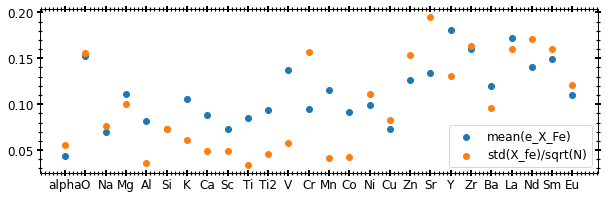

sample size: 7
sample size: 9


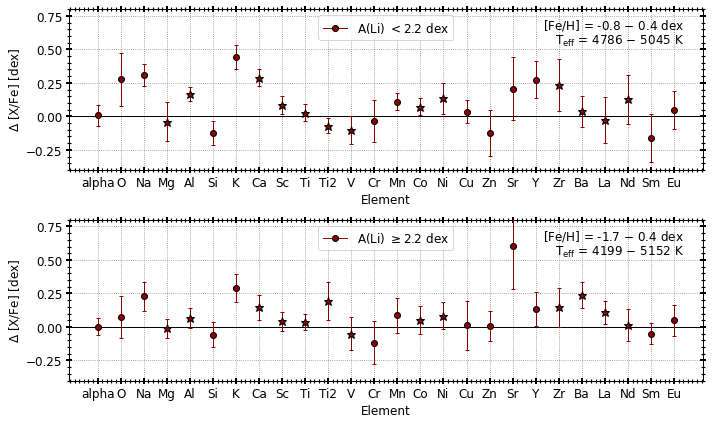

In [157]:
def divide_in_li(abundances,abundance_err):
    PLOT_PARAMS(LS=12, SIZE=12)
    binary = rv_df[rv_df.sobject_id.isin(table4.sobject_id)]
    
    dg_table = pd.read_csv('../../lithium/final_paper_sample_09_18.csv')
    
    below = table4[table4.Li_val < 2.2]
    above = table4[table4.Li_val >= 2.2]
    
    REFRACTORY  = ['Zr_fe','Ni_fe','La_fe','Ba_fe','Al_fe','Sc_fe','Ca_fe','Ti_fe','Nd_fe','V_fe','Co_fe','Mg_fe','Ti2_fe']
    # C, Cr2, Sc2 were removed b/c of NaN values
    # Li was removed b/c it was too large and I wanted to perserve the scale
    # Ru, Rb and Mo were removed b/c of insufficient data points
    
    abundances    = [a for a in abundances if a not in ['Li_fe','C_fe','Cr2_fe','Sc2_fe', 'Ru_fe', 'Rb_fe', 'Mo_fe']]
    abundance_err = [a for a in abundance_err if a not in ['e_Li_fe','e_C_fe','e_Cr2_fe','e_Sc2_fe', 'e_Ru_fe', 'e_Rb_fe', 'e_Mo_fe']]
    
    def check_err(binary):
        df = galah[galah.sobject_id.isin(binary.sobject_id)]
        plt.figure(figsize=(10,3))
        for i,a in enumerate(abundances):
            vals = df[a].values
            err  = df['e_'+a].values
            N = df[a].count()
            plt.scatter(a[:-3], np.nanmean(err),c='C0',label='mean(e_X_Fe)')
            plt.scatter(a[:-3], np.nanstd(vals)/np.sqrt(N),c='C1',label='std(X_fe)/sqrt(N)')
            if i == 0:
                plt.legend()
        plt.show()
    check_err(below)
    
    def run_on_mass_group(binary,color,ax,label):
        print('sample size:',len(binary))
        # binary first
        d    = []
        dg   = []
        
        d_e  = []
        dg_e = []
        
        feh_range  = []
        teff_range = []
        
        for i, row in binary.iterrows():
            sobject_id   = row.sobject_id
            feh_range.append(row.fe_h)
            teff_range.append(row.teff)
            dgs          = find_dg(sobject_id)

            ab_per_star  = galah[galah.sobject_id==sobject_id][abundances].values[0]
            err_per_star = galah[galah.sobject_id==sobject_id][abundance_err].values[0]
            dg_ab_vals   = galah[galah.sobject_id.isin(dgs.sobject_id)][abundances].to_numpy()
            dg_err_vals  = galah[galah.sobject_id.isin(dgs.sobject_id)][abundance_err].to_numpy()
            dg_ab_vals   = np.nanmean(dg_ab_vals, axis=0)
            dg_err_vals  = np.nanmean(dg_err_vals, axis=0)
            
            ab_names     = [a[:-3] for a in abundances if '_fe' in a]
            d.append(ab_per_star)
            dg.append(dg_ab_vals)
            d_e.append(err_per_star)
            dg_e.append(dg_err_vals)

        binary_d   = pd.DataFrame(d,  columns=abundances)
        dg_d       = pd.DataFrame(dg, columns=abundances)

        binary_e   = pd.DataFrame(d_e,  columns=abundance_err)
        dg_e       = pd.DataFrame(dg_e, columns=abundance_err)
        
        feh_label  = '[Fe/H] = %.1f $-$ %.1f dex' % (min(feh_range), max(feh_range))
        teff_label = r'T$_{\rm eff}$ = %i $-$ %i K' % (min(teff_range), max(teff_range))
        
        for i,a in enumerate(abundances):
            # doppelganger
            if a in REFRACTORY:
                marker = '*'
                size   = 9
            else:
                marker = 'o'
                size   = 6
                
            N1         = dg_d[a].count()
            err_notbin = np.std(dg_d[a])/np.sqrt(N1)
            if N1 < 3:
                dg_val = np.nan
            else:
                dg_val = np.nanmean(dg_d[a])
            
            # binary sample
            N2         = binary_d[a].count()
            err_binary = np.std(binary_d[a])/np.sqrt(N2)
            if N2 < 3:
                bin_val = np.nan
            else:
                bin_val = np.nanmean(binary_d[a])

            err  = np.sqrt(err_notbin**2.+err_binary**2.) #add in quadrature
            diff = bin_val - dg_val

            #plt.errorbar(i, dg_val,  yerr=err_notbin, fmt=marker, ms=size, label='dg', capsize=2,lw=1, color='lightgrey',mec='grey',ecolor='grey')
            plt.errorbar(i, diff, yerr=err, fmt=marker, ms=size, label='binary',capsize=2,lw=1, color=color,mec='k',zorder=100)
            
            # calculate 3-sigma difference:
            '''
            if N1 >= 3 and N2 >= 3:
                D       = abs(np.mean(dg_d[a]) - np.mean(binary_d[a]))
                sigma_D = np.sqrt(err_notbin**2 + err_binary**2)
                if (D/sigma_D) >= 3: print('3-sig',a,round(D/sigma_D,2),label,N2)
            '''
            
            # check error of sample:
            err_a = 'e_'+a          
            num = binary_e[err_a].values
            den = binary_d[a].values
            '''
            if i ==0: 
                print('A:\t N1 \t N2',)
                print(a,N1,'\t', N2)
            else:
                print(a, '\t',N1,'\t', N2,'sigma: %.2f' % (100*(np.nanmean(binary_e[err_a]/binary_d[a]) ) ))
            '''
        xlabels = [x[0:-3] for x in abundances]
        ax.set_xticks(np.arange(len(xlabels)))
        ax.set_xticklabels(xlabels)

        # text
        ax.text(0.97, 0.95, feh_label, transform=ax.transAxes,fontsize=12, ha='right', va='top')
        ax.text(0.97, 0.85, teff_label, transform=ax.transAxes,fontsize=12, ha='right', va='top')
        
        plt.grid(ls='dotted',c='grey')
        plt.ylabel('$\Delta$ [X/Fe] [dex]')
        plt.xlabel('Element')
        plt.axhline(0, c='k', lw=1)
        plt.tight_layout()
        #plt.savefig('../plots/abundance_%s.png'%DATE,bbox_inches='tight',dpi=150)
        
    color = 'darkred'
    plt.figure(figsize=(10,6))
    ax1 = plt.subplot(211)
    run_on_mass_group(below,color=color,ax=ax1,label='below')
    
    ax2 = plt.subplot(212)
    run_on_mass_group(above,color=color,ax=ax2,label='above')

    for ax in [ax1,ax2]:
        ax.set_ylim(-0.4,0.8)
    
    lgnd1 = [Line2D([0], [0], marker='o', label=r'A(Li) $< 2.2$ dex', mfc=color, color=color, mec='k', lw=1), ]
    lgnd2 = [Line2D([0], [0], marker='o', label=r'A(Li) $\geq 2.2$ dex', mfc=color, color=color, mec='k', lw=1), ]

    ax1.legend(handles=lgnd1,loc='upper center')
    ax2.legend(handles=lgnd2,loc='upper center')
    
    plt.tight_layout()
    plt.savefig('../plots/ab_li_groups_%s.png'%DATE,bbox_inches='tight',dpi=150)                                               
    
divide_in_li(abundances,abundance_err)

6 3 5 2
sample size: 6
3-sig K_fe 3.11 bd 6


sample size: 3
3-sig O_fe 3.57 wd 3
3-sig Na_fe 4.32 wd 3
3-sig K_fe 3.55 wd 3
3-sig Ca_fe 3.36 wd 3
3-sig Mn_fe 3.6 wd 3


sample size: 5
3-sig V_fe 3.1 md 3


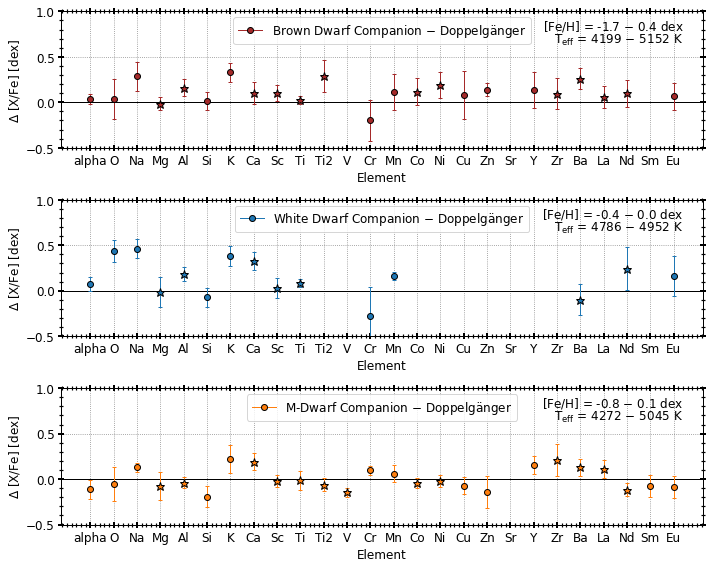

In [114]:
def compare_el_with_dgs(abundances,abundance_err):
    PLOT_PARAMS(LS=12, SIZE=12)
    binary = rv_df[rv_df.sobject_id.isin(table4.sobject_id)]
    
    
    dg_table = pd.read_csv('../../lithium/final_paper_sample_09_18.csv')
    
    wd_limit    = (0.4*u.Msun).to(u.Mjup).value
    md_limit1   = (0.08*u.Msun).to(u.Mjup).value
    md_limit2   = (0.55*u.Msun).to(u.Mjup).value
    brown_dwarf = table4[(table4.Mj50<=80) & (table4.Mj50>=13)]
    white_dwarf = table4[(table4.Mj50>=wd_limit)]
    other       = table4[(table4.Mj50<=13)]
    m_dwarf     = table4[(table4.Mj50<=md_limit2) & (table4.Mj50>=md_limit1)]

    print(len(brown_dwarf),len(white_dwarf),len(m_dwarf) ,len(other))
    
    brown_dwarf = binary[binary.sobject_id.isin(brown_dwarf.sobject_id)]
    white_dwarf = binary[binary.sobject_id.isin(white_dwarf.sobject_id)]
    m_dwarf     = binary[binary.sobject_id.isin(m_dwarf.sobject_id)]
    
    REFRACTORY  = ['Zr_fe','Ni_fe','La_fe','Ba_fe','Al_fe','Sc_fe','Ca_fe','Ti_fe','Nd_fe','V_fe','Co_fe','Mg_fe','Ti2_fe']
    # C, Cr2, Sc2 were removed b/c of NaN values
    # Li was removed b/c it was too large and I wanted to perserve the scale
    # Ru, Rb and Mo were removed b/c of insufficient data points
    abundances    = [a for a in abundances if a not in ['Li_fe','C_fe','Cr2_fe','Sc2_fe', 'Ru_fe', 'Rb_fe', 'Mo_fe']]
    abundance_err = [a for a in abundances if a not in ['e_Li_fe','e_C_fe','e_Cr2_fe','e_Sc2_fe', 'e_Ru_fe', 'e_Rb_fe', 'e_Mo_fe']]
    
    def run_on_mass_group(binary,color,ax,label):
        print('sample size:',len(binary))
        # binary first
        d   = []
        dg  = []
        feh_range  = []
        teff_range = []
        
        for i, row in binary.iterrows():
            sobject_id   = row.sobject_id
            feh_range.append(row.fe_h)
            teff_range.append(row.teff)
            dgs          = find_dg(sobject_id)
            ab_per_star  = galah[galah.sobject_id==sobject_id][abundances].values[0]
            err_per_star = galah[galah.sobject_id==sobject_id][abundance_err].values[0]
            dg_ab_vals   = galah[galah.sobject_id.isin(dgs.sobject_id)][abundances].to_numpy()
            dg_err_vals  = galah[galah.sobject_id.isin(dgs.sobject_id)][abundance_err].to_numpy()
            dg_ab_vals   = np.nanmean(dg_ab_vals, axis=0)
            
            ab_names     = [a[:-3] for a in abundances if '_fe' in a]
            d.append(ab_per_star)
            dg.append(dg_ab_vals)

        binary_d   = pd.DataFrame(d,  columns=abundances)
        dg_d       = pd.DataFrame(dg, columns=abundances)
        
        feh_label  = '[Fe/H] = %.1f $-$ %.1f dex' % (min(feh_range), max(feh_range))
        teff_label = r'T$_{\rm eff}$ = %i $-$ %i K' % (min(teff_range), max(teff_range))
        
        for i,a in enumerate(abundances):
            # doppelganger
            if a in REFRACTORY:
                marker = '*'
                size   = 9
            else:
                marker = 'o'
                size   = 6
                
            N1         = dg_d[a].count()
            err_notbin = np.std(dg_d[a])/np.sqrt(N1)
            if N1 < 3:
                dg_val = np.nan
            else:
                dg_val = np.nanmean(dg_d[a])
            
            # binary sample
            N2         = binary_d[a].count()
            err_binary = np.std(binary_d[a])/np.sqrt(N2)
            if N2 < 3:
                bin_val = np.nan
            else:
                bin_val = np.nanmean(binary_d[a])

            err  = np.sqrt(err_notbin**2.+err_binary**2.) #add in quadrature
            diff = bin_val - dg_val
            
            #plt.errorbar(i, dg_val,  yerr=err_notbin, fmt=marker, ms=size, label='dg', capsize=2,lw=1, color='lightgrey',mec='grey',ecolor='grey')
            plt.errorbar(i, diff, yerr=err, fmt=marker, ms=size, label='binary',capsize=2,lw=1, color=color,mec='k',zorder=100)
            
            # calculate 3-sigma difference:
            if N1 >= 3 and N2 >= 3:
                D       = abs(np.mean(dg_d[a]) - np.mean(binary_d[a]))
                sigma_D = np.sqrt(err_notbin**2 + err_binary**2)
                if (D/sigma_D) >= 3: print('3-sig',a,round(D/sigma_D,2),label,N2)
            #if a in ['Zr_fe','Y_fe','La_fe','Ba_fe'] and label=='wd': 
            #    print('s-process',a, N2, round((D/sigma_D), 2), label)
#             if a in ['K_fe','Na_fe','O_fe','Ca_fe'] and label=='wd':
#                 print(a, N2, round((D/sigma_D), 2), label)
            '''if i ==0: 
                print('A:\t N1 \t N2',)
                print(a,N1,'\t', N2)
            else:
                print(a, '\t',N1,'\t', N2)'''
        xlabels = [x[0:-3] for x in abundances]
        ax.set_xticks(np.arange(len(xlabels)))
        ax.set_xticklabels(xlabels)

        # text
        ax.text(0.97, 0.95, feh_label, transform=ax.transAxes,fontsize=12, ha='right', va='top')
        ax.text(0.97, 0.85, teff_label, transform=ax.transAxes,fontsize=12, ha='right', va='top')
        
        plt.grid(ls='dotted',c='grey')
        plt.ylabel('$\Delta$ [X/Fe] [dex]')
        plt.xlabel('Element')
        plt.axhline(0, c='k', lw=1)
        plt.tight_layout()
        #plt.savefig('../plots/abundance_%s.png'%DATE,bbox_inches='tight',dpi=150)
        
    plt.figure(figsize=(10,8))
    
    
    ax1 = plt.subplot(311)
    run_on_mass_group(brown_dwarf,color='brown',ax=ax1,label='bd')
    print('\n')

    ax2 = plt.subplot(312)
    run_on_mass_group(white_dwarf,color='C0',ax=ax2,label='wd')
    print('\n')
    
    ax3 = plt.subplot(313)
    run_on_mass_group(m_dwarf,color='C1',ax=ax3,label='md')

    lgnd1 = [Line2D([0], [0], marker='o', label=r'Brown Dwarf Companion $-$ Doppelgänger', mfc='brown', color='brown', mec='k', lw=1), ]
    lgnd2 = [Line2D([0], [0], marker='o', label=r'White Dwarf Companion $-$ Doppelgänger', mfc='C0', color='C0', mec='k', lw=1), ]
    lgnd3 = [Line2D([0], [0], marker='o', label=r'M-Dwarf Companion $-$ Doppelgänger', mfc='C1', color='C1', mec='k', lw=1), ]
    
    ax1.legend(handles=lgnd1,loc='upper center')
    ax2.legend(handles=lgnd2,loc='upper center')
    ax3.legend(handles=lgnd3,loc='upper center')
    
    for ax in [ax1,ax2,ax3]:
        ax.set_ylim(-0.5,1.0)
    
    plt.tight_layout()
    #plt.savefig('../plots/abundance_doppelganger_%s.png'%DATE,bbox_inches='tight',dpi=150)
    
compare_el_with_dgs(abundances,abundance_err)


In [24]:
ss

NameError: name 'ss' is not defined

In [93]:
def find_dg(star):
    dg_table = pd.read_csv('../../lithium/final_paper_sample_09_18.csv')
    df_rich  = pd.read_pickle('../../lithium/data/gfinal_rich_low_fidelity.pkl')
    df_poor  = pd.read_pickle('../../lithium/data/gfinal_poor_low_fidelity.pkl')

    f, m, t, l = galah[galah.sobject_id==star][['fe_h','Mg_fe','teff','logg']].to_numpy()[0]
    ef, em, et, el = galah[galah.sobject_id==star][['e_fe_h','e_Mg_fe','e_teff','e_logg']].to_numpy()[0]
    snr = galah[galah.sobject_id==star]['snr_c3_iraf'].values[0]
    
    teff_err, logg_err, fe_err, mg_err = 100, 0.23, 0.07, 0.07    
    df_poor = df_poor[(abs(df_poor.teff - t) <= teff_err) & \
                      (abs(df_poor.logg - l) <= logg_err) & \
                      (abs(df_poor.fe_h - f) <= fe_err) & \
                      (abs(df_poor.Mg_fe - m) <= mg_err)]

    
    df_poor  = df_poor[abs(df_poor.snr_c3_iraf - snr) <= 50.]
    
    
    norm_param = (df_poor.teff-t)**2/(df_poor.e_teff**2 + et**2) + \
                (df_poor.logg-l)**2/(df_poor.e_logg**2 + el**2) + \
                (df_poor.fe_h-f)**2/(df_poor.e_fe_h**2 + ef**2) + \
                (df_poor.Mg_fe-m)**2/(df_poor.e_Mg_fe**2 + em**2)

    df_poor['norm'] = norm_param
    
    df_poor = df_poor.sort_values(by=['norm'])
    #print('N dgs:',len(df_poor))
    return df_poor.head(10)#[['dr2_source_id','sobject_id','teff','logg','fe_h','Mg_fe','norm','snr_c3_iraf']].head(10)
    
find_dg(160129003601260)
    

,star_id,sobject_id,dr2_source_id,dr3_source_id,survey_name,field_id,flag_repeat,wg4_field,wg4_pipeline,flag_sp,...,zpt_ll2020,parallax_corr,r_med_geo,r_lo_geo,r_hi_geo,r_med_photogeo,r_lo_photogeo,r_hi_photogeo,flag_edr3dist,norm
264157,b'10185126-4410296',160522002101214,5414362565073905664,5414362565073905664,b'galah_main',4205,0,b'10k_27',b'lbol',0,...,-0.018167,1.298124,774.151855,757.699097,789.947510,767.111023,750.712891,782.495544,b'10033',0.462006
226895,b'10163645-3827436',160415002601155,5420900256911506048,5420900256911506048,b'galah_main',5061,0,b'10k_25',b'lbol',0,...,-0.013989,0.519098,1932.255371,1883.484375,1999.896484,1945.986450,1888.464111,2002.008057,b'10033',0.622360
287500,b'18510495-5418598',160812003101160,6650459375543387264,6650459375543387264,b'galah_main',1590,0,b'10k_25',b'lbol',1,...,-0.040914,0.333912,3283.575684,2756.226318,4121.837402,3556.340088,2768.869385,4167.502930,b'10033',0.622714
20992,b'07000995-5244449',140316001801189,5503765676590239360,5503765676590239360,b'galah_main',2154,0,b'10k_26',b'lbol',0,...,-0.009801,0.505753,1975.543579,1941.583984,2020.458618,1979.552124,1946.062134,2009.928711,b'10033',0.684380
551368,b'06573983+0705085',180126002601288,3154004530832855552,3154004530832855552,b'other',7432,0,b'10k_24',b'lbol',0,...,-0.028954,0.464985,2172.921631,2063.731445,2282.909912,2161.584473,2080.506104,2283.367676,b'10033',0.702382
308189,b'21461701-2812117',161009003201249,6809901343386991104,6809901343386991104,b'galah_main',0,0,b'10k_17',b'lbol',0,...,-0.043209,0.392019,2559.209473,2454.121582,2666.873291,2511.947510,2380.042969,2627.445557,b'10033',0.791127
420999,b'09412742-7008214',170506002401371,5243375312814752512,5243375312814752512,b'galah_main',3195,0,b'10k_26',b'lbol',0,...,-0.015046,0.525221,1912.162598,1879.997437,1941.430786,1890.940430,1863.082031,1919.898804,b'10033',0.853357
548816,b'10211971-3139143',180102004101025,5460783087002654464,5460783087002654464,b'other',7423,0,b'10k_24',b'lbol',0,...,-0.039105,0.341081,2957.127686,2851.369141,3061.228271,3005.484375,2886.625732,3118.496826,b'10033',0.879427


In [ ]:
table4.keys()

26


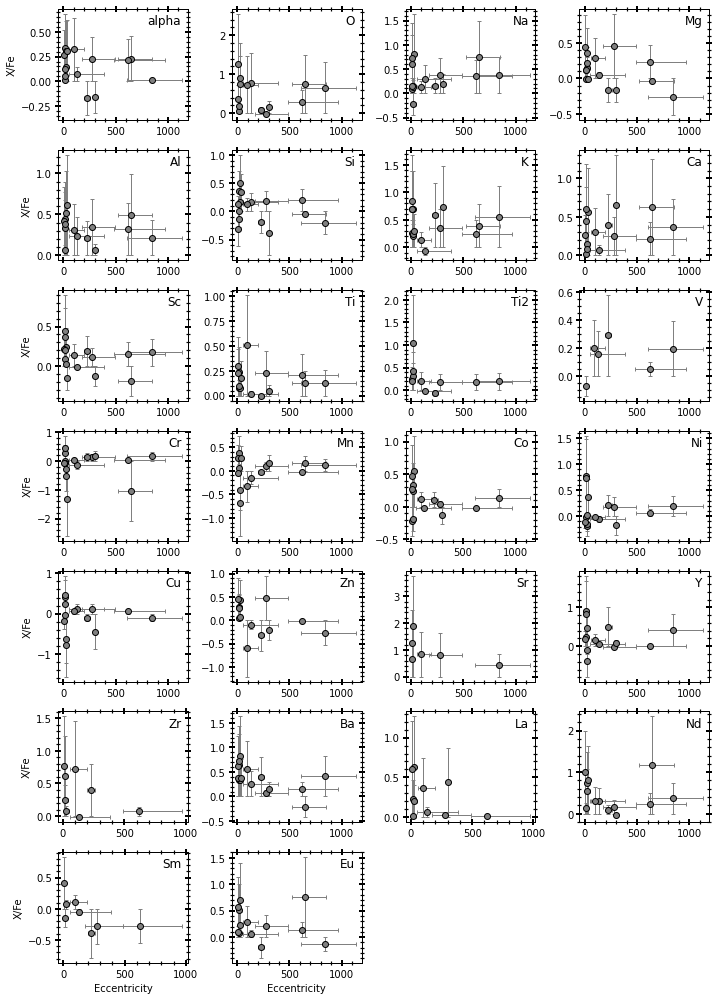

In [208]:
def abs_ecc(abundances):
    PLOT_PARAMS(LS=10, SIZE=10)
    binary = rv_df[rv_df.sobject_id.isin(table4.sobject_id)]
    
    # C, Cr2, Sc2 were removed b/c of NaN values
    # Li was removed b/c it was too large and I wanted to perserve the scale
    # Ru, Rb and Mo were removed b/c of insufficient data points
    abundances = [a for a in abundances if a not in ['Li_fe','C_fe','Cr2_fe','Sc2_fe', 'Ru_fe', 'Rb_fe', 'Mo_fe']]
    abundance_err = [a for a in abundances if a not in ['e_Li_fe','e_C_fe','e_Cr2_fe','e_Sc2_fe', 'e_Ru_fe', 'e_Rb_fe', 'e_Mo_fe']]
    
    d, d_e = [], []
    ecc, e16, e84 = [], [], []
    per, p16, p84 = [], [], []
    
    for i, row in binary.iterrows():
        sobject_id   = row.sobject_id
        ab_per_star  = galah[galah.sobject_id==sobject_id][abundances].values[0]
        err_per_star = galah[galah.sobject_id==sobject_id][abundance_err].values[0]
        ab_names     = [a[:-3] for a in abundances if '_fe' in a]
        e            = table4[table4.sobject_id==sobject_id].e50.values[0]
        e1           = table4[table4.sobject_id==sobject_id].e16.values[0]
        e2           = table4[table4.sobject_id==sobject_id].e84.values[0]
        p            = table4[table4.sobject_id==sobject_id].P50.values[0]
        p1           = table4[table4.sobject_id==sobject_id].P16.values[0]
        p2           = table4[table4.sobject_id==sobject_id].P84.values[0]
        
        d.append(ab_per_star)
        d_e.append(err_per_star)
        ecc.append(e)
        e16.append(e1)
        e84.append(e2)
        per.append(p)
        p16.append(p1)
        p84.append(p2)
        
    
    d   = pd.DataFrame(d, columns=abundances)
    d_err = pd.DataFrame(d_e, columns=abundances)
    
    d['e50'] = ecc
    d['e16'] = e16
    d['e84'] = e84
    d['p50'] = per
    d['p16'] = p16
    d['p84'] = p84
    
    print(len(abundances))
    
    plt.figure(figsize=(10,14))
    
    for i,a in enumerate(abundances):
        ax=plt.subplot(7,4,i+1)

        x1 = (d.e50-d.e16).values
        x2 = (d.e84-d.e50).values
        
        plt.errorbar(d.e50, d[a], xerr= [x1, x2], yerr=abs(d_err[a]), fmt='o', mec='k', color='grey',lw=1,capsize=2)
        ax.text(0.95, 0.95, a[:-3], transform=ax.transAxes,fontsize=12, ha='right', va='top')
        
        if i % 4 == 0: plt.ylabel('X/Fe')
        if i + 1 > 24: plt.xlabel('Eccentricity')
        
    plt.tight_layout()
    #plt.savefig('../plots/abundance_vs_ecc_%s.png'%DATE,bbox_inches='tight',dpi=150)
    
    plt.figure(figsize=(10,14))
    for i,a in enumerate(abundances):
        ax=plt.subplot(7,4,i+1)

        x1 = (d.p50-d.p16).values
        x2 = (d.p84-d.p50).values
        
        plt.errorbar(d.p50, d[a], xerr= [x1, x2], yerr=abs(d_err[a]), fmt='o', mec='k', color='grey',lw=1,capsize=2)
        plt.xscale('log')
        ax.text(0.95, 0.95, a[:-3], transform=ax.transAxes,fontsize=12, ha='right', va='top')
        
        if i % 4 == 0: plt.ylabel('X/Fe')
        if i + 1 > 24: plt.xlabel('Period [days]')
            
    plt.tight_layout()
    #plt.savefig('../plots/abundance_vs_per_%s.png'%DATE,bbox_inches='tight',dpi=150)
    
abs_ecc(abundances) 

In [199]:
0 % 4

0